<div class="alert alert-danger">
    <h4 style="font-weight: bold; font-size: 28px;">Random Forest Models with Basic Feature Set</h4>
    <h5 style="font-weight: bold; font-size: 24px;">Test Set using Expanding Window</h5>
    <p style="font-size: 20px;">NBA API Seasons 2021-22 to 2023-24</p>
</div>

<a name="Models"></a>

# Table of Contents

[Setup](#Setup)

[Data](#Data)

[Inspect Expanding Training Window](#Inspect-Training-Windows)

**[1. Target: Total Points (over / under)](#1.-Target:-Total-Points-(over-/-under))**
  
**[2. Target: Difference in Points (plus / minus)](#2.-Target:-Difference-in-Points-(plus-/-minus))**

**[3. Target: Game Winner (moneyline)](#3.-Target:-Game-Winner-(moneyline))**

# Setup

[Return to top](#Models)

In [1]:
# basic modules
import os
import time
import random as rn
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from functools import reduce
import itertools
import json

# plotting style
plt.style.use('seaborn-v0_8-notebook')
sns.set_style('white')
#sns.set_style('darkgrid')

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

# preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
 
# models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (
  BaggingClassifier, BaggingRegressor, RandomForestClassifier, RandomForestRegressor,
  AdaBoostClassifier, GradientBoostingClassifier
)
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import StackingClassifier, StackingRegressor

# metrics & utilities 
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import (
  accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score,  
  roc_curve, RocCurveDisplay, auc, average_precision_score, precision_recall_curve, 
  PrecisionRecallDisplay, precision_score, recall_score, f1_score, mean_squared_error
)
from sklearn.utils import resample, class_weight

# variable importance
import shap
from shap.explainers import Tree
from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import permutation_importance

# warnings
import warnings
warnings.filterwarnings("ignore")

# user defined functions
import utility_functions as utl

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Data

[Return to top](#Models)

Data splits:

- Define NBA Season 2021-22 as the TRAINING set: regular season is 2021-10-19 to 2022-04-10. 
- Define NBA Season 2022-23 as the VALIDATION set: regular season is 2022-10-18 to 2023-04-09.
- Define NBA Season 2023-24 as the TESTING set: regular season is 2023-10-24 to 2024-04-14.

In [2]:
# load, filter (by time) and scale data
pts_scaled_df, pm_scaled_df, res_scaled_df = utl.load_and_scale_data(
    file_path='../data/processed/nba_team_matchups_rolling_box_scores_2022_2024_r05.csv',
    seasons_to_keep=['2021-22', '2022-23', '2023-24'], 
    training_season='2021-22',
    scaler_type='minmax', 
    scale_target=False
)

Season 2021-22: 1186 games
Season 2022-23: 1181 games
Season 2023-24: 692 games
Total number of games across sampled seasons: 3059 games


In [3]:
# define number of games in seasons
season_22_ngames = 1186
season_23_ngames = 1181

In [4]:
pts_scaled_df.head()

,ROLL_HOME_PTS,ROLL_HOME_FGM,ROLL_HOME_FGA,ROLL_HOME_FG_PCT,ROLL_HOME_FG3M,ROLL_HOME_FG3A,ROLL_HOME_FG3_PCT,ROLL_HOME_FTM,ROLL_HOME_FTA,ROLL_HOME_FT_PCT,ROLL_HOME_OREB,ROLL_HOME_DREB,ROLL_HOME_REB,ROLL_HOME_AST,ROLL_HOME_STL,ROLL_HOME_BLK,ROLL_HOME_TOV,ROLL_HOME_PF,ROLL_AWAY_PTS,ROLL_AWAY_FGM,ROLL_AWAY_FGA,ROLL_AWAY_FG_PCT,ROLL_AWAY_FG3M,ROLL_AWAY_FG3A,ROLL_AWAY_FG3_PCT,ROLL_AWAY_FTM,ROLL_AWAY_FTA,ROLL_AWAY_FT_PCT,ROLL_AWAY_OREB,ROLL_AWAY_DREB,ROLL_AWAY_REB,ROLL_AWAY_AST,ROLL_AWAY_STL,ROLL_AWAY_BLK,ROLL_AWAY_TOV,ROLL_AWAY_PF,TOTAL_PTS
1,113.000,45.0,94.00,0.479,15.000,35.000,0.429,8.000,9.000,0.889,6.000,49.000,55.000,31.000,8.000,9.000,13.000,16.000,82.000,34.000,88.000,0.386,5.000,28.000,0.179,9.00,15.00,0.600,11.000,42.00,53.000,14.0,9.00,8.000,20.00,17.00,226
2,117.500,45.5,92.00,0.495,13.500,33.500,0.402,13.000,15.000,0.873,8.000,44.000,52.000,27.500,9.500,6.000,13.000,17.500,101.333,37.333,86.667,0.434,7.667,30.333,0.259,19.00,25.00,0.761,9.333,41.00,50.333,18.0,9.00,6.667,16.00,18.00,229
3,117.667,43.0,89.00,0.483,13.333,33.667,0.395,18.333,19.667,0.915,9.667,40.667,50.333,26.333,9.333,5.667,12.333,17.333,109.500,37.000,85.500,0.435,13.750,40.750,0.336,21.75,24.75,0.886,11.000,40.75,51.750,17.0,8.25,6.000,16.25,17.75,214
4,112.750,41.0,87.25,0.469,11.750,32.250,0.359,19.000,21.250,0.889,8.500,37.250,45.750,24.250,9.750,5.250,11.500,19.000,110.800,41.400,92.200,0.450,16.800,41.800,0.396,11.20,16.00,0.703,12.400,36.00,48.400,23.6,7.40,4.800,12.00,15.80,220
5,114.200,42.2,89.20,0.472,12.400,32.800,0.373,17.400,19.600,0.880,9.800,37.000,46.800,23.600,9.000,4.400,11.600,19.000,105.400,37.000,85.000,0.435,14.600,39.200,0.384,16.80,22.80,0.724,10.400,37.40,47.800,21.8,5.00,5.600,15.80,22.20,240


In [5]:
pm_scaled_df.head()

,ROLL_HOME_PTS,ROLL_HOME_FGM,ROLL_HOME_FGA,ROLL_HOME_FG_PCT,ROLL_HOME_FG3M,ROLL_HOME_FG3A,ROLL_HOME_FG3_PCT,ROLL_HOME_FTM,ROLL_HOME_FTA,ROLL_HOME_FT_PCT,ROLL_HOME_OREB,ROLL_HOME_DREB,ROLL_HOME_REB,ROLL_HOME_AST,ROLL_HOME_STL,ROLL_HOME_BLK,ROLL_HOME_TOV,ROLL_HOME_PF,ROLL_AWAY_PTS,ROLL_AWAY_FGM,ROLL_AWAY_FGA,ROLL_AWAY_FG_PCT,ROLL_AWAY_FG3M,ROLL_AWAY_FG3A,ROLL_AWAY_FG3_PCT,ROLL_AWAY_FTM,ROLL_AWAY_FTA,ROLL_AWAY_FT_PCT,ROLL_AWAY_OREB,ROLL_AWAY_DREB,ROLL_AWAY_REB,ROLL_AWAY_AST,ROLL_AWAY_STL,ROLL_AWAY_BLK,ROLL_AWAY_TOV,ROLL_AWAY_PF,PLUS_MINUS
1,113.000,45.0,94.00,0.479,15.000,35.000,0.429,8.000,9.000,0.889,6.000,49.000,55.000,31.000,8.000,9.000,13.000,16.000,82.000,34.000,88.000,0.386,5.000,28.000,0.179,9.00,15.00,0.600,11.000,42.00,53.000,14.0,9.00,8.000,20.00,17.00,18.0
2,117.500,45.5,92.00,0.495,13.500,33.500,0.402,13.000,15.000,0.873,8.000,44.000,52.000,27.500,9.500,6.000,13.000,17.500,101.333,37.333,86.667,0.434,7.667,30.333,0.259,19.00,25.00,0.761,9.333,41.00,50.333,18.0,9.00,6.667,16.00,18.00,7.0
3,117.667,43.0,89.00,0.483,13.333,33.667,0.395,18.333,19.667,0.915,9.667,40.667,50.333,26.333,9.333,5.667,12.333,17.333,109.500,37.000,85.500,0.435,13.750,40.750,0.336,21.75,24.75,0.886,11.000,40.75,51.750,17.0,8.25,6.000,16.25,17.75,-18.0
4,112.750,41.0,87.25,0.469,11.750,32.250,0.359,19.000,21.250,0.889,8.500,37.250,45.750,24.250,9.750,5.250,11.500,19.000,110.800,41.400,92.200,0.450,16.800,41.800,0.396,11.20,16.00,0.703,12.400,36.00,48.400,23.6,7.40,4.800,12.00,15.80,20.0
5,114.200,42.2,89.20,0.472,12.400,32.800,0.373,17.400,19.600,0.880,9.800,37.000,46.800,23.600,9.000,4.400,11.600,19.000,105.400,37.000,85.000,0.435,14.600,39.200,0.384,16.80,22.80,0.724,10.400,37.40,47.800,21.8,5.00,5.600,15.80,22.20,18.0


In [6]:
res_scaled_df.head()

,ROLL_HOME_PTS,ROLL_HOME_FGM,ROLL_HOME_FGA,ROLL_HOME_FG_PCT,ROLL_HOME_FG3M,ROLL_HOME_FG3A,ROLL_HOME_FG3_PCT,ROLL_HOME_FTM,ROLL_HOME_FTA,ROLL_HOME_FT_PCT,ROLL_HOME_OREB,ROLL_HOME_DREB,ROLL_HOME_REB,ROLL_HOME_AST,ROLL_HOME_STL,ROLL_HOME_BLK,ROLL_HOME_TOV,ROLL_HOME_PF,ROLL_AWAY_PTS,ROLL_AWAY_FGM,ROLL_AWAY_FGA,ROLL_AWAY_FG_PCT,ROLL_AWAY_FG3M,ROLL_AWAY_FG3A,ROLL_AWAY_FG3_PCT,ROLL_AWAY_FTM,ROLL_AWAY_FTA,ROLL_AWAY_FT_PCT,ROLL_AWAY_OREB,ROLL_AWAY_DREB,ROLL_AWAY_REB,ROLL_AWAY_AST,ROLL_AWAY_STL,ROLL_AWAY_BLK,ROLL_AWAY_TOV,ROLL_AWAY_PF,GAME_RESULT
1,113.000,45.0,94.00,0.479,15.000,35.000,0.429,8.000,9.000,0.889,6.000,49.000,55.000,31.000,8.000,9.000,13.000,16.000,82.000,34.000,88.000,0.386,5.000,28.000,0.179,9.00,15.00,0.600,11.000,42.00,53.000,14.0,9.00,8.000,20.00,17.00,1
2,117.500,45.5,92.00,0.495,13.500,33.500,0.402,13.000,15.000,0.873,8.000,44.000,52.000,27.500,9.500,6.000,13.000,17.500,101.333,37.333,86.667,0.434,7.667,30.333,0.259,19.00,25.00,0.761,9.333,41.00,50.333,18.0,9.00,6.667,16.00,18.00,1
3,117.667,43.0,89.00,0.483,13.333,33.667,0.395,18.333,19.667,0.915,9.667,40.667,50.333,26.333,9.333,5.667,12.333,17.333,109.500,37.000,85.500,0.435,13.750,40.750,0.336,21.75,24.75,0.886,11.000,40.75,51.750,17.0,8.25,6.000,16.25,17.75,0
4,112.750,41.0,87.25,0.469,11.750,32.250,0.359,19.000,21.250,0.889,8.500,37.250,45.750,24.250,9.750,5.250,11.500,19.000,110.800,41.400,92.200,0.450,16.800,41.800,0.396,11.20,16.00,0.703,12.400,36.00,48.400,23.6,7.40,4.800,12.00,15.80,1
5,114.200,42.2,89.20,0.472,12.400,32.800,0.373,17.400,19.600,0.880,9.800,37.000,46.800,23.600,9.000,4.400,11.600,19.000,105.400,37.000,85.000,0.435,14.600,39.200,0.384,16.80,22.80,0.724,10.400,37.40,47.800,21.8,5.00,5.600,15.80,22.20,1


# Inspect Expanding Training Window

[Return to top](#Models)

In [7]:
# expanding window configuration
initial_train_size = 10  # starting size of the training set
test_size = 1            # leave-one-out (LOO) cross-validation

counter = 0
max_splits_to_show = 15

# show first few splits
for train_indices, test_indices in utl.expanding_window_ts_split(pts_scaled_df, initial_train_size, test_size=test_size):
    print("TRAIN:", train_indices, "TEST:", test_indices)
    counter += 1
    if counter >= max_splits_to_show:
        break

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [14]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] TEST: [15]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] TEST: [16]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] TEST: [17]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [18]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] TEST: [19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] TEST: [21]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST: [22]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9

<a name="1.-Target:-Total-Points-(over-/-under)"></a>
# 1. Target: Total Points (over / under)

[Return to top](#Models)

In [8]:
# load the best hyperparameters dictionary back from the file
with open('../hyperparameters/RF_pts_best_params.json', 'r') as json_file:
    best_params = json.load(json_file)

# configuration for total points with expanding window
initial_train_size = season_22_ngames + season_23_ngames # starting size of the training set
expansion_limit = None    # maximum number of new training observations in expansion
test_size = 1             # leave-one-out (LOO) cross-validation
df = pts_scaled_df        # data set to use
target_col = 'TOTAL_PTS'  # target column name

# train over expanding window
model_outputs, y_true = utl.train_with_expanding_window(
    df=df,  
    initial_train_size=initial_train_size, 
    expansion_limit=expansion_limit,
    test_size=test_size,           
    target_col=target_col, 
    model=RandomForestRegressor(**best_params)
)

Total time taken: 659.06 seconds


In [9]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 19.55


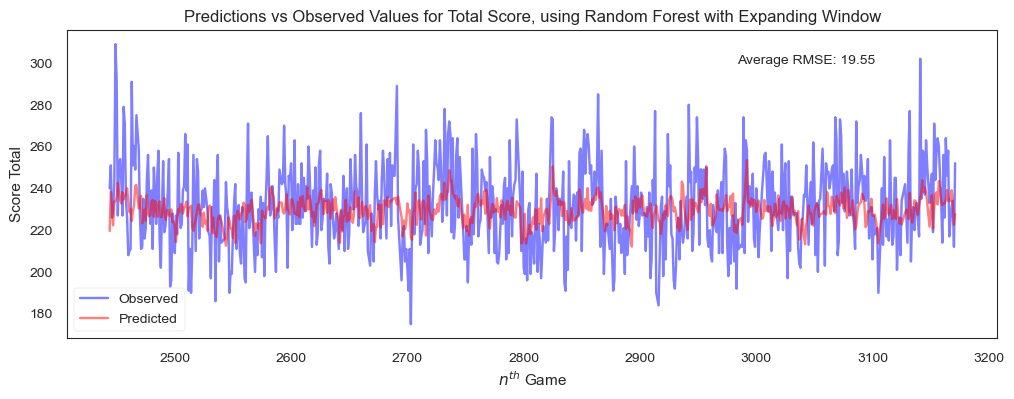

In [10]:
# set end_index based on whether an expansion_limit is specified
if expansion_limit is not None:
    end_index = initial_train_size + expansion_limit * test_size
else:
    # use the length of model_outputs to determine end_index when no limit is specified
    end_index = initial_train_size + len(model_outputs) * test_size

# adjust the observed_values slice accordingly
observed_values = df[target_col][initial_train_size:end_index]
# ensure lengths are the same (for sanity check)
assert len(model_outputs) == len(observed_values), "Length mismatch between predictions and observed values."

# plot
plt.figure(figsize=(12, 4))
plt.plot(observed_values.index, observed_values, label='Observed', color='blue', alpha=0.5)
plt.plot(observed_values.index, model_outputs, label='Predicted', color='red', alpha=0.5)
plt.title('Predictions vs Observed Values for Total Score, using Random Forest with Expanding Window')
plt.xlabel(r'$n^{th}$ Game')
plt.ylabel('Score Total')
plt.text(x=0.72, y=0.92, s=f"Average RMSE: {metrics['average_rmse']:.2f}", transform=plt.gca().transAxes, 
         ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))
plt.legend();

<a name="2.-Target:-Difference-in-Points-(plus-/-minus)"></a>
# 2. Target: Difference in Points (plus / minus)

[Return to top](#Models)

In [11]:
# load the best hyperparameters dictionary back from the file
with open('../hyperparameters/RF_pm_best_params.json', 'r') as json_file:
    best_params = json.load(json_file)

# configuration for points difference with expanding window
initial_train_size = season_22_ngames + season_23_ngames # starting size of the training set
expansion_limit = None    # maximum number of new training observations in expansion
test_size = 1             # leave-one-out (LOO) cross-validation
df = pm_scaled_df         # data set to use
target_col = 'PLUS_MINUS' # target column name

# train over expanding window
model_outputs, y_true = utl.train_with_expanding_window(
    df=df,  
    initial_train_size=initial_train_size, 
    expansion_limit=expansion_limit,
    test_size=test_size,           
    target_col=target_col, 
    model=RandomForestRegressor(**best_params)
)

Total time taken: 1270.96 seconds


In [12]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 14.85


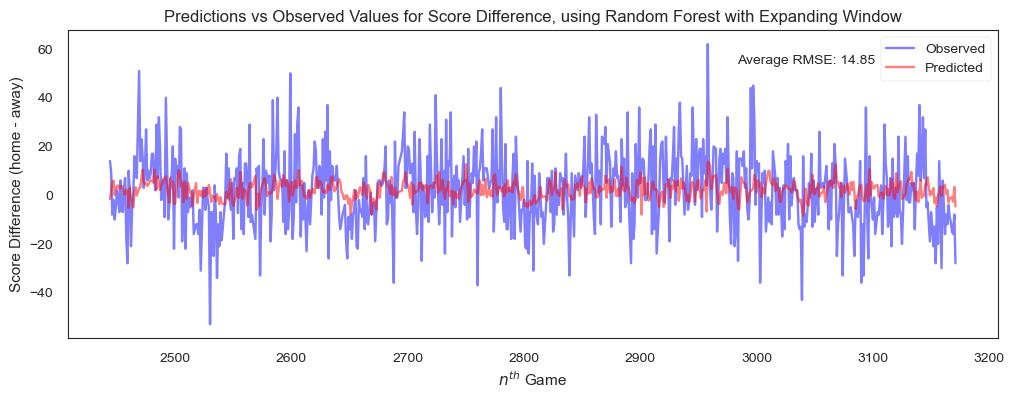

In [13]:
# set end_index based on whether an expansion_limit is specified
if expansion_limit is not None:
    end_index = initial_train_size + expansion_limit * test_size
else:
    # use the length of model_outputs to determine end_index when no limit is specified
    end_index = initial_train_size + len(model_outputs) * test_size

# adjust the observed_values slice accordingly
observed_values = df[target_col][initial_train_size:end_index]
# ensure lengths are the same (for sanity check)
assert len(model_outputs) == len(observed_values), "Length mismatch between predictions and observed values."

# plot
plt.figure(figsize=(12, 4))
plt.plot(observed_values.index, observed_values, label='Observed', color='blue', alpha=0.5)
plt.plot(observed_values.index, model_outputs, label='Predicted', color='red', alpha=0.5)
plt.title('Predictions vs Observed Values for Score Difference, using Random Forest with Expanding Window')
plt.xlabel(r'$n^{th}$ Game')
plt.ylabel('Score Difference (home - away)')
plt.text(x=0.72, y=0.92, s=f"Average RMSE: {metrics['average_rmse']:.2f}", transform=plt.gca().transAxes, 
         ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))
plt.legend();

<a name="3.-Target:-Game-Winner-(moneyline)"></a>
# 3. Target: Game Winner (moneyline)

[Return to top](#Models)

In [14]:
# load the best hyperparameters dictionary back from the file
with open('../hyperparameters/RF_res_best_params.json', 'r') as json_file:
    best_params = json.load(json_file)

# configuration for game winner with expanding window
initial_train_size = season_22_ngames + season_23_ngames  # starting size of the training set
expansion_limit = None      # maximum number of new training observations in expansion
test_size = 1               # leave-one-out (LOO) cross-validation
df = res_scaled_df          # data set to use
target_col = 'GAME_RESULT'  # target column name

# train over expanding window
model_outputs, y_true = utl.train_with_expanding_window(
    df=df,  
    initial_train_size=initial_train_size, 
    expansion_limit=expansion_limit,
    test_size=test_size,           
    target_col=target_col, 
    model=RandomForestClassifier(**best_params),
    ensure_diversity=True # ensure class diversity in training
)

Total time taken: 72.74 seconds


In [15]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Classification Metrics:
- Average Accuracy: 0.56
- Overall AUC: 0.48
- Average F1 Score: 0.72


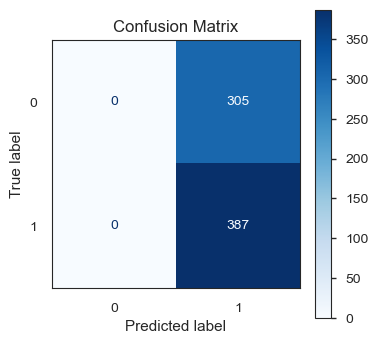

In [16]:
# calculate confusion matrix
cm = confusion_matrix(y_true, metrics['pred_labels'])

# plot
fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix');

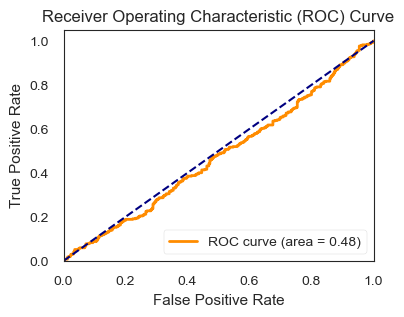

In [17]:
# calculate FPR (False Positive Rate), TPR (True Positive Rate), and threshold values
fpr, tpr, thresholds = roc_curve(y_true, model_outputs)

# calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right");